# **moviematch**

we decided to embark on this project to attempt implementing a recommendation system. 

this notebook implements three recommendation approaches:
1. **Neural Collaborative Filtering (NCF)** - Learns user-item interactions through deep learning
2. **Content-Based Filtering** - Recommends based on movie features (genres, tags, year)
3. **Hybrid Model** - Combines both approaches for robust recommendations

## **setup**

In [1]:
# %% Import all required libraries
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
import os
from difflib import get_close_matches
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load MovieLens data
ratings = pd.read_csv("./data/ratings.csv")
movies = pd.read_csv("./data/movies.csv")
tags = pd.read_csv("./data/tags.csv")

print(f"Ratings: {ratings.shape[0]:,} ratings from {ratings['userId'].nunique():,} users on {ratings['movieId'].nunique():,} movies")
print(f"Movies: {movies.shape[0]:,} movies with genres")
print(f"Tags: {tags.shape[0]:,} tags applied to movies")

Ratings: 100,836 ratings from 610 users on 9,724 movies
Movies: 87,585 movies with genres
Tags: 2,000,072 tags applied to movies


## **ncf**

NCF uses embeddings to represent users and movies in a latent space, then uses a Multi-Layer Perceptron (MLP) to predict ratings.

**rationale**: Traditional matrix factorization assumes linear interactions. NCF can capture non-linear user-item relationships.

In [3]:
# Prepare data for NCF
ratings_ncf = ratings.drop(columns=["timestamp"])

# Create index mappings for embedding layers
user_ids = ratings_ncf["userId"].unique()
movie_ids = ratings_ncf["movieId"].unique()

user2idx = {user: idx for idx, user in enumerate(user_ids)}
movie2idx = {movie: idx for idx, movie in enumerate(movie_ids)}
idx2user = {idx: user for user, idx in user2idx.items()}
idx2movie = {idx: movie for movie, idx in movie2idx.items()}

ratings_ncf["user_idx"] = ratings_ncf["userId"].map(user2idx)
ratings_ncf["movie_idx"] = ratings_ncf["movieId"].map(movie2idx)

num_users = len(user2idx)
num_movies = len(movie2idx)

print(f"Embedding dimensions: {num_users:,} users × {num_movies:,} movies")

Embedding dimensions: 610 users × 9,724 movies


### ncf architecture
 
- **embedding layers**: Map user/movie IDs to dense vectors
- **MLP layers**: Learn non-linear interactions between user and movie embeddings
- **dropout**: Prevent overfitting on sparse data

In [4]:
print("Rating statistics:")
print(f"Mean rating: {ratings['rating'].mean():.2f}")
print(f"Std rating: {ratings['rating'].std():.2f}")
print(f"Min rating: {ratings['rating'].min()}")
print(f"Max rating: {ratings['rating'].max()}")
print("\nRating distribution:")
print(ratings['rating'].value_counts().sort_index())

Rating statistics:
Mean rating: 3.50
Std rating: 1.04
Min rating: 0.5
Max rating: 5.0

Rating distribution:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


In [5]:
class NCF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=50, hidden_dims=[128, 64, 32]):
        super(NCF, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        # Better initialization - very important!
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.movie_embedding.weight)
        
        # Build MLP layers
        layers = []
        input_dim = embedding_dim * 2
        
        for dim in hidden_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dim))  # Add batch normalization
            layers.append(nn.Dropout(0.2))
            input_dim = dim
        
        # Output layer - predict rating between 0.5 and 5.0
        layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*layers)
        
        # Output activation to constrain predictions to valid rating range
        self.output_activation = nn.Sigmoid()
        
    def forward(self, user_ids, movie_ids):
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        
        x = torch.cat([user_emb, movie_emb], dim=-1)
        x = self.mlp(x).squeeze()
        
        # Scale output to rating range [0.5, 5.0]
        x = self.output_activation(x) * 4.5 + 0.5
        
        return x

In [6]:
class MovieDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df["user_idx"].values, dtype=torch.long)
        self.movies = torch.tensor(df["movie_idx"].values, dtype=torch.long)
        self.ratings = torch.tensor(df["rating"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

In [7]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for users, movies, ratings in loader:
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        predictions = model(users, movies)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for users, movies, ratings in loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            predictions = model(users, movies)
            loss = criterion(predictions, ratings)
            total_loss += loss.item()
    
    return total_loss / len(loader)

### train ncf model
 
**split strategy**: 80% train, 10% validation, 10% test
- train: learn parameters
- validation: select best model
- test: final evaluation

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create NEW model (not loading anything yet)
model = NCF(num_users, num_movies).to(device)

# Use a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Split data
train_df, test_df = train_test_split(ratings_ncf, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Create dataloaders
train_loader = DataLoader(MovieDataset(train_df), batch_size=1024, shuffle=True)
val_loader = DataLoader(MovieDataset(val_df), batch_size=1024, shuffle=False)
test_loader = DataLoader(MovieDataset(test_df), batch_size=1024, shuffle=False)

# Define criterion
criterion = nn.MSELoss()


Using device: cpu
Train size: 72601
Validation size: 8067
Test size: 20168


In [9]:
# Create directory for models
import os
os.makedirs('./models', exist_ok=True)

# Train with early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 10

epochs = 50  # More epochs but with early stopping
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './models/best_ncf_model.pth')
        patience_counter = 0    
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Best Val: {best_val_loss:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 2/50, Train Loss: 1.4441, Val Loss: 1.2010, Best Val: 1.1940
Epoch 4/50, Train Loss: 1.2934, Val Loss: 1.1173, Best Val: 1.1173
Epoch 6/50, Train Loss: 1.1860, Val Loss: 1.0458, Best Val: 1.0458
Epoch 8/50, Train Loss: 1.0726, Val Loss: 0.9588, Best Val: 0.9588
Epoch 10/50, Train Loss: 0.9677, Val Loss: 0.8983, Best Val: 0.8983
Epoch 12/50, Train Loss: 0.8810, Val Loss: 0.8531, Best Val: 0.8531
Epoch 14/50, Train Loss: 0.8157, Val Loss: 0.8292, Best Val: 0.8292
Epoch 16/50, Train Loss: 0.7665, Val Loss: 0.8090, Best Val: 0.8090
Epoch 18/50, Train Loss: 0.7275, Val Loss: 0.7918, Best Val: 0.7918
Epoch 20/50, Train Loss: 0.6916, Val Loss: 0.7825, Best Val: 0.7825
Epoch 22/50, Train Loss: 0.6618, Val Loss: 0.7764, Best Val: 0.7764
Epoch 24/50, Train Loss: 0.6373, Val Loss: 0.7739, Best Val: 0.7739
Epoch 26/50, Train Loss: 0.6076, Val Loss: 0.7737, Best Val: 0.7737
Epoch 28/50, Train Loss: 0.5910, Val Loss: 0.7724, Best Val: 0.7724
Epoch 30/50, Train Loss: 0.5659, Val Loss: 0.7704, B

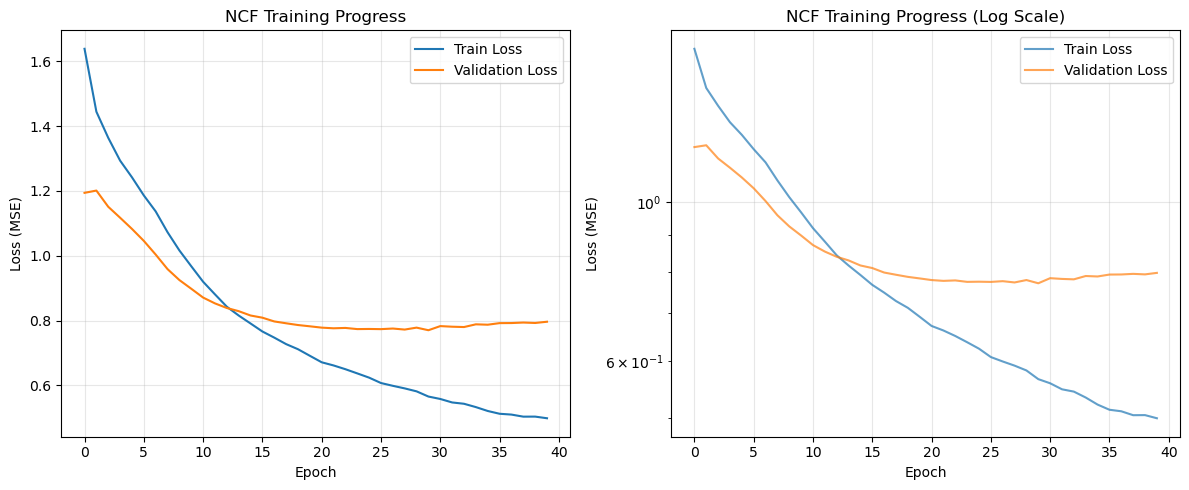

In [10]:
# Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('NCF Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('NCF Training Progress (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Sanity Check
model.eval()
sample_size = 10
sample_users = torch.tensor(train_df['user_idx'].iloc[:sample_size].values, dtype=torch.long).to(device)
sample_movies = torch.tensor(train_df['movie_idx'].iloc[:sample_size].values, dtype=torch.long).to(device)
sample_actual = train_df['rating'].iloc[:sample_size].values

with torch.no_grad():
    sample_predictions = model(sample_users, sample_movies).cpu().numpy()

print("\nSample predictions vs actual:")
for i in range(sample_size):
    print(f"User {sample_users[i].item()}, Movie {sample_movies[i].item()}: "
          f"Predicted={sample_predictions[i]:.2f}, Actual={sample_actual[i]:.1f}")



Sample predictions vs actual:
User 609, Movie 9071: Predicted=4.01, Actual=4.0
User 599, Movie 862: Predicted=3.06, Actual=3.0
User 273, Movie 2906: Predicted=3.81, Actual=3.5
User 539, Movie 753: Predicted=4.37, Actual=4.0
User 100, Movie 1608: Predicted=4.11, Actual=4.0
User 54, Movie 1036: Predicted=2.73, Actual=3.0
User 109, Movie 3641: Predicted=3.05, Actual=3.0
User 204, Movie 774: Predicted=3.97, Actual=4.0
User 598, Movie 9255: Predicted=2.93, Actual=3.0
User 413, Movie 28: Predicted=4.46, Actual=4.0


### ncf recommendation function

In [12]:
# %% Recommendation Function
def get_ncf_recommendations(user_id, model, num_movies, movie2idx, idx2movie, movies_df, top_k=10):
    """
    Generate top-k movie recommendations for a user using the trained NCF model.
    
    Rationale: Score all movies for the user and return highest predicted ratings.
    """
    model.eval()
    
    if user_id not in user2idx:
        return None
    
    user_idx = user2idx[user_id]
    
    # Create tensors for all movies
    all_movie_indices = torch.tensor(list(range(num_movies)), dtype=torch.long).to(device)
    user_indices = torch.full((num_movies,), user_idx, dtype=torch.long).to(device)
    
    # Predict ratings for all movies
    with torch.no_grad():
        predictions = model(user_indices, all_movie_indices)
    
    # Get top-k movies
    _, top_indices = torch.topk(predictions, top_k)
    top_movie_ids = [idx2movie[idx.item()] for idx in top_indices]
    
    # Return movie details
    recommendations = movies_df[movies_df['movieId'].isin(top_movie_ids)]
    return recommendations[['movieId', 'title', 'genres']].head(top_k)

# Test NCF recommendations
example_user = ratings['userId'].iloc[0]
ncf_recs = get_ncf_recommendations(example_user, model, num_movies, movie2idx, idx2movie, movies)
print(f"\nNCF Recommendations for user {example_user}:")
print(ncf_recs)


NCF Recommendations for user 1:
       movieId                                              title  \
884        905                       It Happened One Night (1934)   
1186      1217                                         Ran (1985)   
2640      2732                Jules and Jim (Jules et Jim) (1961)   
3121      3214                             American Flyers (1985)   
9019     26840                        Sonatine (Sonachine) (1993)   
17822    93022                                 Miss Nobody (2010)   
19354   100507                                 21 and Over (2013)   
20862   107771                      Only Lovers Left Alive (2013)   
28555   131724  The Jinx: The Life and Deaths of Robert Durst ...   
40985   159817                                Planet Earth (2006)   

                          genres  
884               Comedy|Romance  
1186                   Drama|War  
2640               Drama|Romance  
3121                       Drama  
9019   Action|Comedy|Crime|Drama

## **content-based filtering**

uses movie features (genres, tags, year) to find similar movies based on what users have liked before.
 
**rationale**: solves cold start problem and provides explainable recommendations based on movie characteristics.


In [13]:
# Prepare movie content features
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x.astype(str).unique())).reset_index()
movies_content = movies.merge(tags_grouped, on='movieId', how='left')
movies_content['tag'] = movies_content['tag'].fillna('')

# Extract year from title
movies_content['year'] = movies_content['title'].str.extract(r'\((\d{4})\)')

# Combine all text features
movies_content['content'] = (
    movies_content['genres'].str.replace('|', ' ') + ' ' + 
    movies_content['tag'] + ' ' + 
    movies_content['year'].fillna('').astype(str)
)

print("Sample movie content:")
print(movies_content[['title', 'content']].head(3))

Sample movie content:
                     title                                            content
0         Toy Story (1995)  Adventure Animation Children Comedy Fantasy ch...
1           Jumanji (1995)  Adventure Children Fantasy Robin Williams fant...
2  Grumpier Old Men (1995)  Comedy Romance comedinha de velhinhos engraÃƒÂ...


### tf-idf vectorization

**TF-IDF** (Term Frequency-Inverse Document Frequency) converts text to numerical vectors:
- **TF**: how often a word appears in a document
- **IDF**: how rare the word is across all documents
- **Bigrams**: captures two-word phrases for better context

In [14]:
# Create TF-IDF matrix
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=3000,
    ngram_range=(1, 2)  # Use both unigrams and bigrams
)
tfidf_matrix = tfidf.fit_transform(movies_content['content'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Sample features: {tfidf.get_feature_names_out()[:10]}")


TF-IDF matrix shape: (87585, 3000)
Sample features: ['01' '01 11' '02' '02 11' '03' '03 11' '05' '05 11' '06' '06 11']


In [15]:
# Calculate cosine similarity between all movies
if 'cosine_sim' not in locals():
    n_movies = tfidf_matrix.shape[0]
    cosine_sim = np.zeros((n_movies, n_movies), dtype=np.float32)  # Use float32 to save memory
    
    # Process in chunks of 1000 movies at a time
    chunk_size = 1000
    for i in range(0, n_movies, chunk_size):
        end_i = min(i + chunk_size, n_movies)
        for j in range(0, n_movies, chunk_size):
            end_j = min(j + chunk_size, n_movies)
            cosine_sim[i:end_i, j:end_j] = cosine_similarity(
                tfidf_matrix[i:end_i], 
                tfidf_matrix[j:end_j]
            ).astype(np.float32)
        print(f"Processed {end_i}/{n_movies} movies...")
    
    print(f"Similarity matrix shape: {cosine_sim.shape}")

Processed 1000/87585 movies...
Processed 2000/87585 movies...
Processed 3000/87585 movies...
Processed 4000/87585 movies...
Processed 5000/87585 movies...
Processed 6000/87585 movies...
Processed 7000/87585 movies...
Processed 8000/87585 movies...
Processed 9000/87585 movies...
Processed 10000/87585 movies...
Processed 11000/87585 movies...
Processed 12000/87585 movies...
Processed 13000/87585 movies...
Processed 14000/87585 movies...
Processed 15000/87585 movies...
Processed 16000/87585 movies...
Processed 17000/87585 movies...
Processed 18000/87585 movies...
Processed 19000/87585 movies...
Processed 20000/87585 movies...
Processed 21000/87585 movies...
Processed 22000/87585 movies...
Processed 23000/87585 movies...
Processed 24000/87585 movies...
Processed 25000/87585 movies...
Processed 26000/87585 movies...
Processed 27000/87585 movies...
Processed 28000/87585 movies...
Processed 29000/87585 movies...
Processed 30000/87585 movies...
Processed 31000/87585 movies...
Processed 32000/8

> **note**  
the above method takes longer, but uses less memory at any given time. it was used because the previous method resulted in the kernel crashing.

### content-based recommendation functions

In [16]:
def get_similar_movies(movie_title, movies_df, cosine_sim, top_n=10):
    """
    Find movies similar to a given movie based on content features.
    """
    # Find movie in dataset
    matches = movies_df[movies_df['title'].str.contains(movie_title, case=False, na=False)]
    
    if matches.empty:
        # Try fuzzy matching for typos
        all_titles = movies_df['title'].tolist()
        close_matches = get_close_matches(movie_title, all_titles, n=3, cutoff=0.6)
        
        if close_matches:
            print(f"Did you mean: {close_matches[0]}?")
            matches = movies_df[movies_df['title'] == close_matches[0]]
        else:
            return None
    
    # Get similarity scores
    idx = matches.index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Get movie details
    movie_indices = [i[0] for i in sim_scores]
    return movies_df.iloc[movie_indices][['movieId', 'title', 'genres']]


In [17]:
def get_content_recommendations(user_id, ratings_df, movies_df, cosine_sim, top_n=10):
    """
    Generate recommendations based on movies the user has liked (rated ≥ 4.0).
    
    Rationale: Aggregate similarity scores from all highly-rated movies to find 
    movies with similar content that the user hasn't seen yet.
    """
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    if user_ratings.empty:
        return None
    
    # Get movies the user liked (4+ stars)
    liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].values
    
    if len(liked_movies) == 0:
        # If no highly rated movies, use top rated movies
        liked_movies = user_ratings.nlargest(5, 'rating')['movieId'].values
    
    # Calculate aggregate similarity scores
    scores = np.zeros(len(movies_df))
    
    for movie_id in liked_movies:
        if movie_id in movies_df['movieId'].values:
            idx = movies_df[movies_df['movieId'] == movie_id].index[0]
            scores += cosine_sim[idx]
    
    # Normalize by number of liked movies
    scores = scores / len(liked_movies)
    
    # Remove already rated movies
    rated_indices = movies_df[movies_df['movieId'].isin(user_ratings['movieId'])].index
    scores[rated_indices] = -1
    
    # Get top recommendations
    top_indices = np.argsort(scores)[::-1][:top_n]
    return movies_df.iloc[top_indices][['movieId', 'title', 'genres']]

In [18]:
# Test content-based filtering
print("Movies similar to 'Toy Story':")
similar = get_similar_movies('Toy Story', movies_content, cosine_sim, top_n=5)
print(similar)

print(f"\nContent-based recommendations for user {example_user}:")
content_recs = get_content_recommendations(example_user, ratings, movies_content, cosine_sim)
print(content_recs)

Movies similar to 'Toy Story':


       movieId                              title  \
3021      3114                 Toy Story 2 (1999)   
60708   201588                 Toy Story 4 (2019)   
14815    78499                 Toy Story 3 (2010)   
24090   120474  Toy Story That Time Forgot (2014)   
73549   239474                   Lamp Life (2020)   

                                                 genres  
3021        Adventure|Animation|Children|Comedy|Fantasy  
60708               Adventure|Animation|Children|Comedy  
14815  Adventure|Animation|Children|Comedy|Fantasy|IMAX  
24090                                Animation|Children  
73549                         Animation|Children|Comedy  

Content-based recommendations for user 1:
       movieId                                              title  \
5841      5952      Lord of the Rings: The Two Towers, The (2002)   
4888      4993  Lord of the Rings: The Fellowship of the Ring,...   
7029      7153  Lord of the Rings: The Return of the King, The...   
581        589

## **hybrid recommender system**

combines NCF and content-based approaches to leverage both collaborative and content signals.

**advantages**:
- NCF captures collaborative patterns (users with similar tastes)
- content-based handles cold start and provides diversity
- weighted combination allows tuning the balance

In [19]:
class HybridRecommender:
    def __init__(self, ncf_model, movies_df, cosine_sim, ratings_df, 
                 user2idx, movie2idx, idx2movie, device='cpu'):
        self.ncf_model = ncf_model
        self.movies = movies_df
        self.cosine_sim = cosine_sim
        self.ratings = ratings_df
        self.user2idx = user2idx
        self.movie2idx = movie2idx
        self.idx2movie = idx2movie
        self.device = device
        
    def get_recommendations(self, user_id, top_n=10, alpha=0.6):
        """
        Generate hybrid recommendations.
        
        Args:
            user_id: User ID
            top_n: Number of recommendations
            alpha: Weight for NCF (0-1). Higher = more collaborative, lower = more content-based
        
        Rationale: 
        - Get 2x recommendations from each method
        - Combine with weighted scores based on ranking position
        - Return top-n from combined list
        """
        # Get recommendations from both methods
        ncf_recs = get_ncf_recommendations(
            user_id, self.ncf_model, len(self.movie2idx), 
            self.movie2idx, self.idx2movie, self.movies, top_k=top_n*2
        )
        
        content_recs = get_content_recommendations(
            user_id, self.ratings, self.movies, self.cosine_sim, top_n=top_n*2
        )
        
        # Handle edge cases
        if ncf_recs is None and content_recs is None:
            return pd.DataFrame(columns=['movieId', 'title', 'genres', 'recommendation_score'])
        elif ncf_recs is None:
            return content_recs.head(top_n)
        elif content_recs is None:
            return ncf_recs.head(top_n)
        
        # Score based on ranking position
        scores = {}
        
        # NCF scores (position-based ranking)
        for i, movie_id in enumerate(ncf_recs['movieId'].values):
            # Higher ranked items get higher scores
            scores[movie_id] = alpha * (len(ncf_recs) - i) / len(ncf_recs)
        
        # Content scores
        for i, movie_id in enumerate(content_recs['movieId'].values):
            if movie_id not in scores:
                scores[movie_id] = 0
            scores[movie_id] += (1 - alpha) * (len(content_recs) - i) / len(content_recs)
        
        # Sort by combined score
        top_movies = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_movie_ids = [m[0] for m in top_movies]
        top_scores = [m[1] for m in top_movies]
        
        # Create results dataframe
        results = self.movies[self.movies['movieId'].isin(top_movie_ids)].copy()
        results['recommendation_score'] = results['movieId'].map(dict(zip(top_movie_ids, top_scores)))
        results = results.sort_values('recommendation_score', ascending=False)
        
        return results[['movieId', 'title', 'genres', 'recommendation_score']]

In [20]:
# Initialize hybrid recommender
hybrid_recommender = HybridRecommender(
    ncf_model=model,
    movies_df=movies_content,
    cosine_sim=cosine_sim,
    ratings_df=ratings,
    user2idx=user2idx,
    movie2idx=movie2idx,
    idx2movie=idx2movie,
    device=device
)

# Test hybrid recommendations
print(f"Hybrid recommendations for user {example_user} (alpha=0.6):")
hybrid_recs = hybrid_recommender.get_recommendations(example_user, top_n=10, alpha=0.6)
print(hybrid_recs)


Hybrid recommendations for user 1 (alpha=0.6):
      movieId                                              title  \
884       905                       It Happened One Night (1934)   
1186     1217                                         Ran (1985)   
2640     2732                Jules and Jim (Jules et Jim) (1961)   
3003     3096                              My Man Godfrey (1957)   
3121     3214                             American Flyers (1985)   
3539     3637                 Vagabond (Sans toit ni loi) (1985)   
5841     5952      Lord of the Rings: The Two Towers, The (2002)   
3575     3675                             White Christmas (1954)   
4888     4993  Lord of the Rings: The Fellowship of the Ring,...   
6884     7008  Last Tango in Paris (Ultimo tango a Parigi) (1...   

                      genres  recommendation_score  
884           Comedy|Romance              0.600000  
1186               Drama|War              0.566667  
2640           Drama|Romance              0.5

### compare different alpha values

alpha controls the balance between collaborative and content-based:
- **α = 1.0**: Pure NCF (collaborative)
- **α = 0.0**: Pure content-based
- **α = 0.6**: Balanced hybrid (default)

In [21]:
print("Testing different alpha values:\n")

for alpha in [0.0, 0.3, 0.6, 0.9]:
    recs = hybrid_recommender.get_recommendations(example_user, top_n=5, alpha=alpha)
    print(f"Alpha = {alpha} (NCF: {alpha*100:.0f}%, Content: {(1-alpha)*100:.0f}%):")
    print(recs[['title', 'genres']].to_string(index=False))
    print()

Testing different alpha values:



Alpha = 0.0 (NCF: 0%, Content: 100%):
                                                    title                         genres
            Lord of the Rings: The Two Towers, The (2002)              Adventure|Fantasy
Lord of the Rings: The Fellowship of the Ring, The (2001)              Adventure|Fantasy
    Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
                        Terminator 2: Judgment Day (1991)                  Action|Sci-Fi
                                    Godfather, The (1972)                    Crime|Drama

Alpha = 0.3 (NCF: 30%, Content: 70%):
                                                    title                         genres
            Lord of the Rings: The Two Towers, The (2002)              Adventure|Fantasy
Lord of the Rings: The Fellowship of the Ring, The (2001)              Adventure|Fantasy
    Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
                        Terminato

## **save models for deployment**

In [22]:
import os
from scipy import sparse

# Create models directory if it doesn't exist
os.makedirs('./models', exist_ok=True)

# Save NCF model and components
torch.save({
    'model_state_dict': model.state_dict(),
    'user2idx': user2idx,
    'movie2idx': movie2idx,
    'idx2user': idx2user,
    'idx2movie': idx2movie,
    'num_users': num_users,
    'num_movies': num_movies
}, './models/ncf_complete.pth')
print("NCF model saved")

# Save movies content
movies_content.to_csv('./models/movies_content.csv', index=False)
print("Movies content saved")

# Save TF-IDF vectorizer
with open('./models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("TF-IDF vectorizer saved")

# Save the TF-IDF matrix (sparse format, much smaller)
sparse.save_npz('./models/tfidf_matrix.npz', tfidf_matrix)
print("TF-IDF matrix saved")

print("\nAll models saved successfully in ./models/ directory")
print("Note: Cosine similarity will be computed on-demand to save space")

NCF model saved
Movies content saved
TF-IDF vectorizer saved
TF-IDF matrix saved

All models saved successfully in ./models/ directory
Note: Cosine similarity will be computed on-demand to save space
